# Grad-CAM
This example interactively demonstrates Grad-CAM using nnabla's pre-trained model.

[Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra. Grad-CAM: Visual explanations from deep networks via gradient-based localization. Proceedings of the IEEE International conference on computer vision, pages 618 - 626, 2017.](https://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html)

Where does machine learning look at images to make decisions? This paper describes Grad-CAM, an algorithm that uses heat maps to indicate the image areas used as the basis for judgment in image classification by CNN [R.R. Selvaraju + 2016]. The principle behind Grad-CAM is to visualize the information on which the decision is based by displaying the location of the large input gradient to the final convolution layer. Grad-CAM allows you to visualize areas of relevance for each prediction class. In the final output, the gradient is backpropagated, with only the specified class being 1 and the other classes being 0, to find the gradient in the feature map. Uses the average slope on each channel as a weight, and adds that weight to the values in the feature map. The Grad-CAM is computed through the activation function ReLU to remove the negative part. The feature is that the operation is very light, so it can be operated at high speed. As an example of application, we can see where the misclassified images were judged. It can also detect cases where misclassification occurs due to gender differences.

![Grad-CAM algorithm](https://github.com/sony/nnabla-examples/raw/master/responsible_ai/gradcam/images/grad-cam_fig.png)

# Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

In [1]:
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!pip install nnabla-ext-cuda116
!git clone https://github.com/sony/nnabla-examples.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.5 MB/s eta 0:00:00
Cloning into 'nnabla-examples'...
remote: Enumerating objects: 9648, done.
remote: Counting objects: 100% (2206/2206), done.
remote: Compressing objects: 100% (916/916), done.
remote: Total 9648 (delta 1291), reused 2077 (delta 1230), pack-reused 7442 (from 1)
Receiving objects: 100% (9648/9648), 299.12 MiB | 32.29 MiB/s, done.
Resolving deltas: 100% (5193/5193), done.
Updating files: 100% (1711/1711), done.


In [2]:
#%cd nnabla-examples/responsible_ai/gradcam

/content/nnabla-examples/responsible_ai/gradcam


Import dependencies

In [10]:
import os
import cv2
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import nnabla as nn
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16

from gradcam import gradcam
from gradcam import overlay_images

from nnabla.ext_utils import get_extension_context


In [39]:
#https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


## Image Preparation
Download image to apply Grad-CAM for.

Take a look at what the image looks like.  
We can see a flower in the middle on which a butterfly rests.

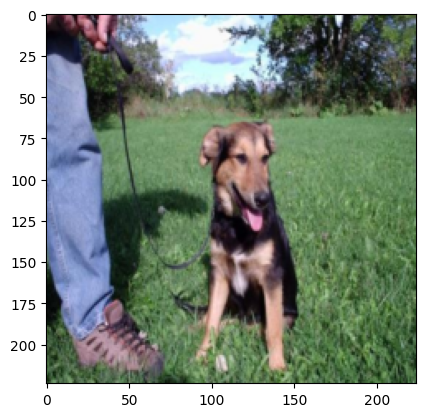

In [47]:
img_path = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/12215.jpg'
img = imread(img_path, size=(224, 224), channel_first=True)
plt.imshow(img.transpose(1,2,0))
plt.show()

## Network Definition
Loading the model is very simple.<br>
You can choose other models such as `VGG11`, `VGG13`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `VGG16` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

In [48]:
model = VGG16()

Loading /root/nnabla_data/nnp_models/imagenet/VGG-16.nnp.


In [54]:
batch_size = 1
x = nn.Variable((batch_size,) + model.input_shape)
# set training True since gradient of variable is necessary for Grad-CAM
vgg = model(x, training=True, returns_net=True)
vgg_variables = vgg.variables

We now define the input, and extract the necessary outputs.  
middle_layer: the last convolution layer  
pred: final output of the model

In [55]:
target_label_indices = {
    'dog': 1
}

input_name = list(vgg.inputs.keys())[0]
vgg_variables[input_name].d = img
middle_layer = vgg_variables['VGG16/ReLU_13']
pred = vgg_variables["VGG16/Affine_3"]
selected = pred[:, target_label_indices['dog']]

Let's see how the model predicted the image.  
We can see the model classified the image as we expect.  
Labels regarding butterfly comes high, while flower is also recognized although it is14th ranked probability.

In [56]:
selected.forward()

In [57]:
predicted_labels = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels[:15]):
        print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

Top 1, Label index: 227,  Label name: kelpie
Top 2, Label index: 235,  Label name: German shepherd, German shepherd dog, German police dog, alsatian
Top 3, Label index: 240,  Label name: Appenzeller
Top 4, Label index: 207,  Label name: golden retriever
Top 5, Label index: 249,  Label name: malamute, malemute, Alaskan malamute
Top 6, Label index: 263,  Label name: Pembroke, Pembroke Welsh corgi
Top 7, Label index: 244,  Label name: Tibetan mastiff
Top 8, Label index: 165,  Label name: black-and-tan coonhound
Top 9, Label index: 234,  Label name: Rottweiler
Top 10, Label index: 273,  Label name: dingo, warrigal, warragal, Canis dingo
Top 11, Label index: 225,  Label name: malinois
Top 12, Label index: 166,  Label name: Walker hound, Walker foxhound
Top 13, Label index: 209,  Label name: Chesapeake Bay retriever
Top 14, Label index: 163,  Label name: bloodhound, sleuthhound
Top 15, Label index: 208,  Label name: Labrador retriever


## Grad-CAM Computation

Execute backward computation to calculate gradient to use for Grad-CAM.

In [58]:
selected.backward()

Let's compute the heatmap using the gradient with respect to the last convolution layer.

In [59]:
heatmap = gradcam(middle_layer)

## Visualization
Take a look at how the heatmap looks like in the layer of interest.

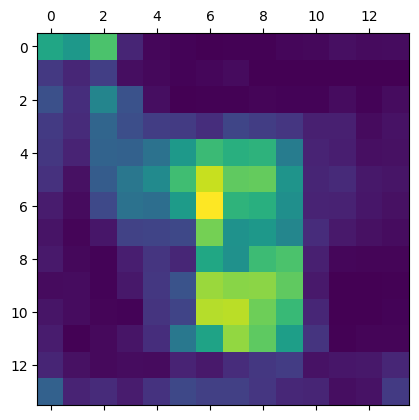

In [60]:
plt.matshow(heatmap)
plt.show()

Then we overlay the heatmap onto the original image to understand where the model focused.

In [61]:
base_img = imread(img_path, size=(224, 224))
overlaid_img_dog = overlay_images(base_img, heatmap)

Now we overlay the heatmap onto the original image to understand where the model focused.  
We can speculate the model recognized the butterfly, focusing on its wing.

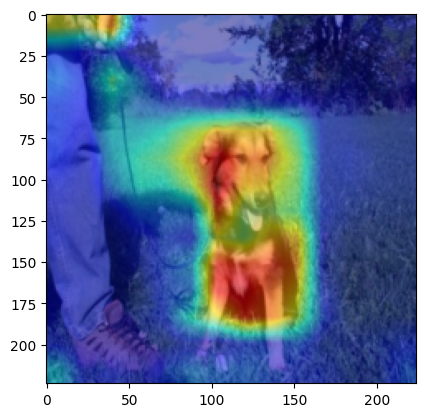

In [62]:
plt.imshow(overlaid_img_dog)
plt.show()

Let's use flower as the label of interest to see how the model see the image this time by calculating Grad-CAM.

Reset gradient first.

In [63]:
for k, v in vgg_variables.items():
    if 'VGG16/' in k:
        v.grad.zero()

Calculate gradient and Grad-CAM same as for butterfly.

Finally, compare images in oneline to enable to see the differences clearly.

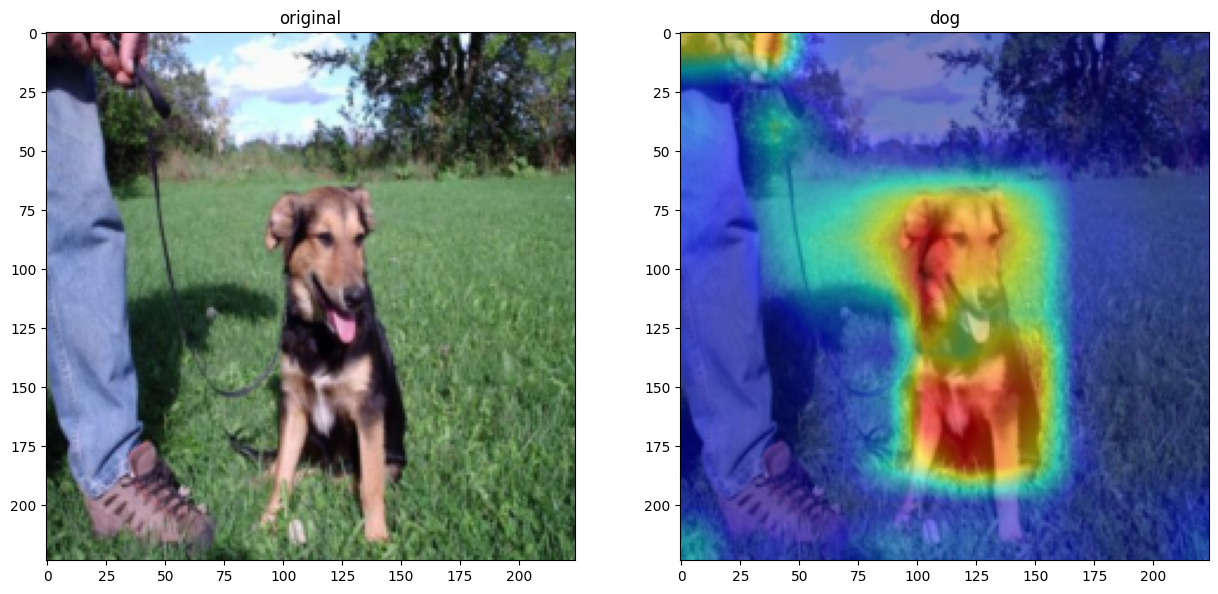

In [67]:
images = {
    'original': base_img,
    'dog': overlaid_img_dog,
}


row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k)

In [ ]:
# prompt: Create an adversarial example for the neural network model trained in last question.

import numpy as np

# Assuming 'img' is the original image and 'model' is the loaded VGG16 model
# and 'x' is the input variable as defined in the previous code

# Epsilon for the adversarial perturbation
epsilon = 0.01

# Target label index (e.g., change to a different class)
target_label = 10  # Example: change to class index 10

# Get the input image
img_perturbed = img.copy()


# Create adversarial example by adding small perturbation to the input image
#  Find the gradient of the loss with respect to the input image.
#  Add the gradient (scaled by a small value epsilon) to the input image.

# Generate adversarial perturbation
# We need the gradients for each pixel.
# This is where backpropagation steps in.

# Assuming 'selected' and 'vgg_variables' are still defined
# Find the gradients of the target class prediction w.r.t. the input pixels
selected.forward()
selected.backward(clear_buffer=True)
gradients = vgg_variables[input_name].g

# Create a perturbation by scaling the gradient
perturbation = epsilon * np.sign(gradients)

# Apply the perturbation to the input image
img_perturbed = img_perturbed + perturbation

# Ensure pixel values are within [0, 255]
img_perturbed = np.clip(img_perturbed, 0, 255)

# Classify the adversarial example
x.d = img_perturbed
pred.forward()
predicted_labels_adv = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels_adv[:15]):
        print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

# Visualize the perturbed image
plt.imshow(img_perturbed.transpose(1,2,0))
plt.show()

In [68]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [69]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [70]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [71]:
image_raw = tf.io.read_file(img_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


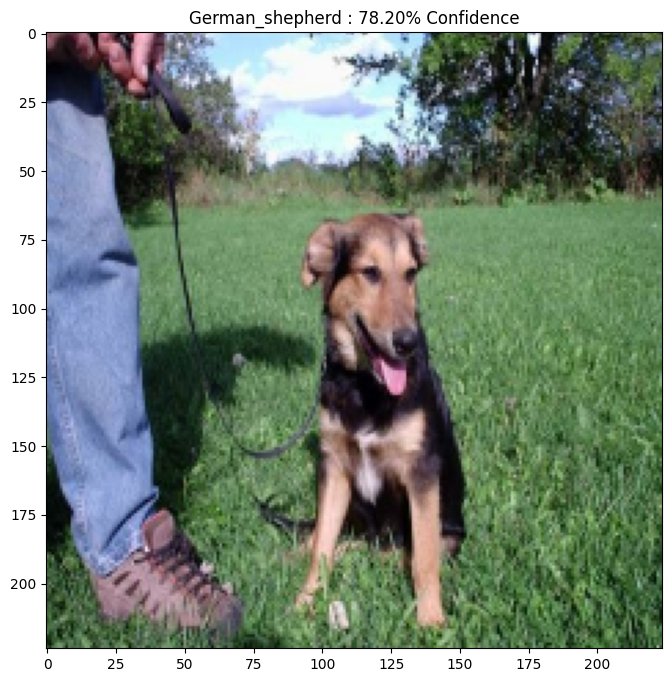

In [72]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [73]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

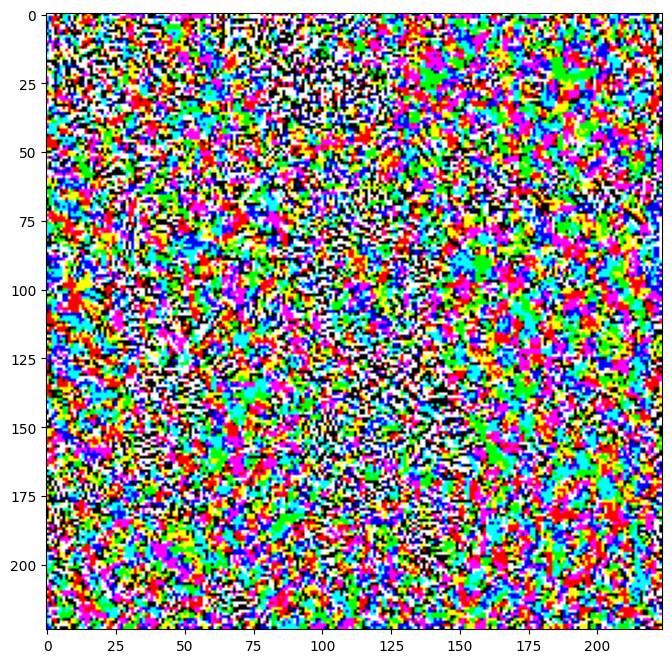

In [74]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [76]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


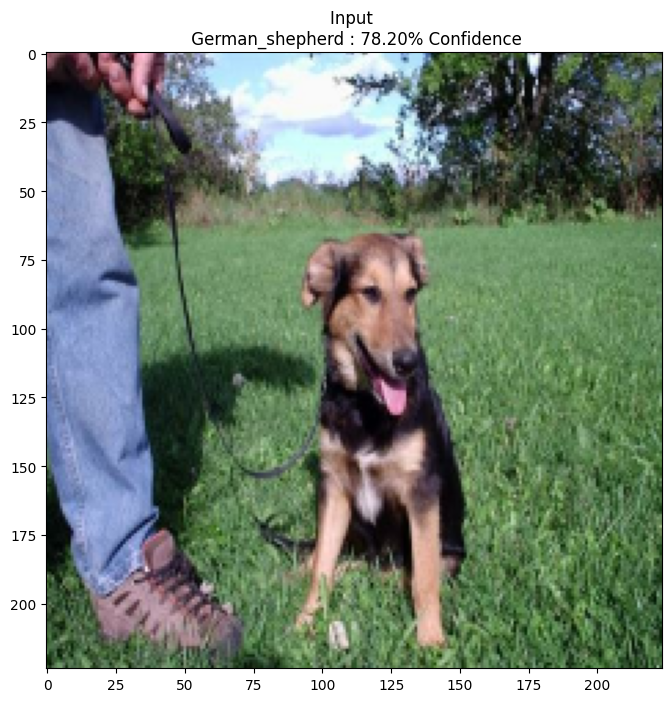

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


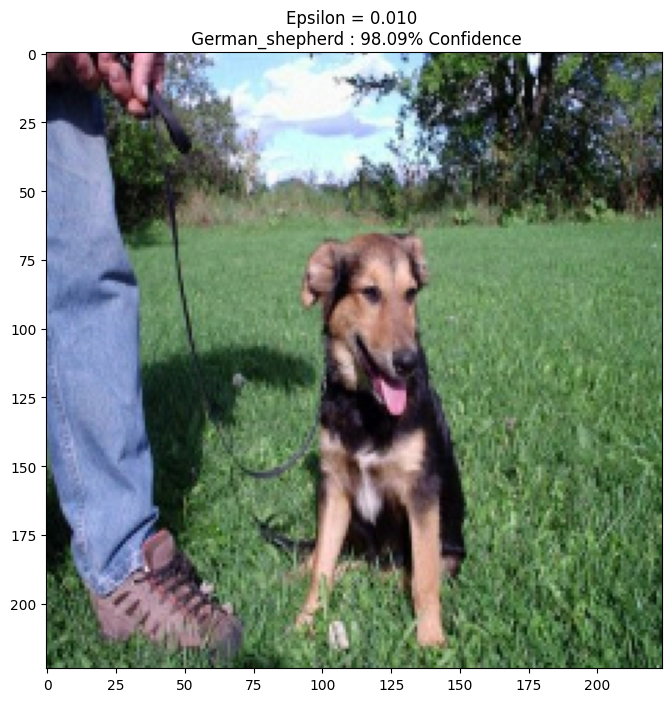

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


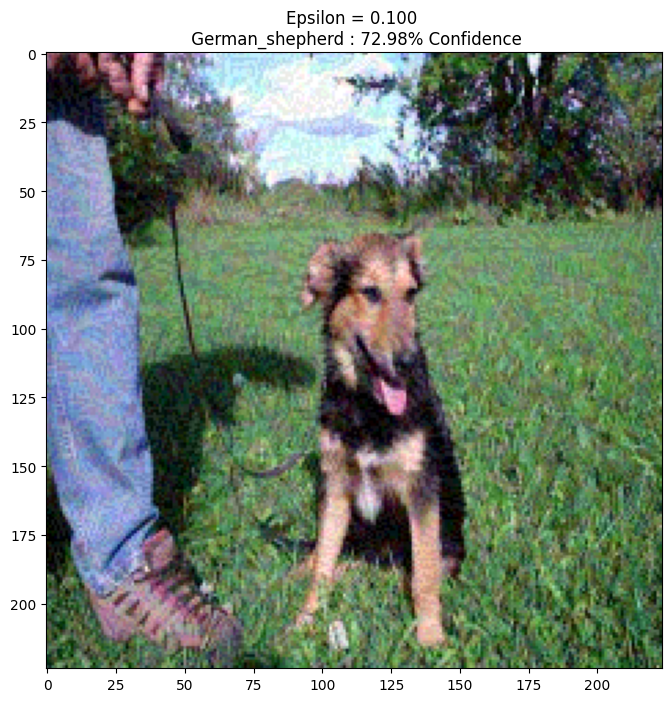

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


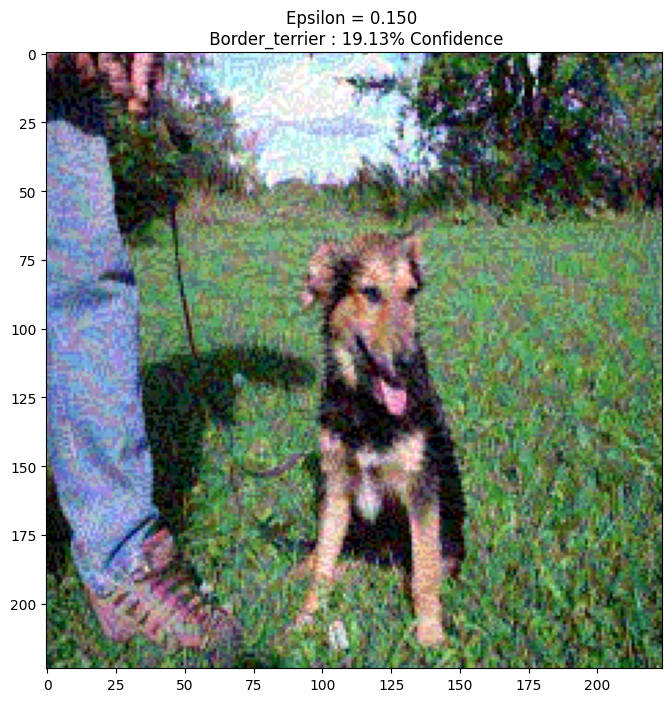

In [77]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

In [46]:
url = '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1'
#img_path = 'input_flower_moth_spider.jpg'
img_path = 'PetImages/Dog/12215.jpg'

if not os.path.isfile(img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(img_path, mode='wb') as f:
       f.write(tgt)
#img_path = 'input_flower_moth_spider.jpg'
img_path = 'PetImages/Dog/12215.jpg'
os.makedirs(os.path.dirname(img_path), exist_ok=True)

if not os.path.isfile(img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(img_path, mode='wb') as f:
       f.write(tgt)

ValueError: unknown url type: '/root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1'